In [3]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import ease

In [4]:
# The function involves four input parameters then returns a result of vote
def rf(prec, ts, tw, ws):
    """
    This function is RandomForest classifier to intake user input temperature,
    precipitation, and windespeed to classify the possible states the user
    will be in, and returns a dictionary with states as the keys and
    the frequency or count as the values of each key.
       input = user input values, integer or float based.
       vote  = dictionary based output that contains the RF classified states,
               and each states frequency.
    """
    import pandas as pd
    from sklearn.ensemble import RandomForestClassifier
    import itertools as it
    import warnings
    
    # read arranged weatehr data, drop elements contained in state DC, and remove warnings
    train = pd.read_csv('../Arranged_Data/final_weater.csv')[[
            'State', 'TotalMonthlyPrecip', 'TempSummer',
            'TempWinter', 'Avgwindspeed']]
    train = train[train.State != 'DC']
    warnings.filterwarnings('ignore')
    
    # set precipitation, summer temperature, winter temperature, and windspeed as input parameters
    # set total number of trees equal to 500
    # creat a list for saving prediction results and a dictonary for vote outcome
    input_ = [prec, ts, tw, ws]
    tree_num = 5000
    pred_list = []
    vote = {}
    rf = RandomForestClassifier(n_estimators = tree_num)
    rf.fit(train.iloc[:,1:5], train.State)

    for i in range(tree_num):
        dt = rf.estimators_[i]
        dt.fit(train.iloc[:,1:5], train.State)
        pred = dt.predict(input_)
        pred_list.append(pred[0])

    pred_key = []
    pred_key_count = []
    for key, group in it.groupby(sorted(pred_list)):
        pred_key.append(key)
        pred_key_count.append(len(list(group)))
    
    # the dictionary of vote contains states as keys and weight percent as values
    for i in range(len(pred_key)):
        vote[pred_key[i]] = pred_key_count[i]/tree_num
    return vote

In [37]:
rf(1, 75, 30, 1.5)

{'AZ': 0.005,
 'CA': 0.0334,
 'CO': 0.0002,
 'GA': 0.0026,
 'ID': 0.1568,
 'KS': 0.0002,
 'KY': 0.0106,
 'MO': 0.0004,
 'NE': 0.0002,
 'NH': 0.0026,
 'NJ': 0.008,
 'NM': 0.0008,
 'NV': 0.0014,
 'OH': 0.0002,
 'OR': 0.01,
 'SD': 0.0022,
 'TN': 0.0014,
 'UT': 0.7384,
 'VA': 0.0006,
 'VT': 0.0012,
 'WV': 0.0238}

In [5]:
# The function returns the average capacity of resources by multiple their average plant capacity with vote results
def avg_capacity(vote):
    """
    creat a null list
    set original resources sum euqal to zero
    for state in vote keys
        average capacity of resource = average plant capacity of particular resource in specific state * vote results specific state
    return average capacity
    """
    average_plant_capacity = pd.read_csv('../Arranged_Data/average_plant_capacity.csv')
    avg_cap_list = []
    coal_sum = 0
    ng_sum = 0
    petro_sum = 0
    hydro_sum = 0
    solar_sum = 0
    wind_sum =0
    for i in vote.keys():
        coal_sum += int(average_plant_capacity.Coal[average_plant_capacity.State == i]) * vote[i]
        ng_sum += int(average_plant_capacity.NG[average_plant_capacity.State == i]) * vote[i]
        petro_sum += int(average_plant_capacity.Petro[average_plant_capacity.State == i]) * vote[i]
        hydro_sum += int(average_plant_capacity.Hydro[average_plant_capacity.State == i]) * vote[i]
        solar_sum += int(average_plant_capacity.Solar[average_plant_capacity.State == i]) * vote[i]
        wind_sum += int(average_plant_capacity.Wind[average_plant_capacity.State == i]) * vote[i]
    return([coal_sum, ng_sum, petro_sum, hydro_sum, solar_sum, wind_sum])

In [6]:
cap_pop = pd.read_csv('../Arranged_Data/average_plant_capacity.csv')
cap_pop[cap_pop.Coal != 0].Coal.mean()

1439076.4893617022

In [7]:
# write up a function to select possible type of resources
def possible_type(avg_cap_list):
    """
    creat a empty list to store results of possible type
    for some type in all types
        calculat p value and set up confidence level as 95%
            if p less than alpha, pass
            else, append possible type to empty list
    return possible type 
    """
    cap_pop = pd.read_csv('../Arranged_Data/average_plant_capacity.csv')
    e_type = ['Coal', 'NG', 'Petro', 'Hydro', 'Solar', 'Wind']
    possible_type_list = []
    for i in range(len(e_type)):
        p_value = stats.ttest_1samp(cap_pop[cap_pop[e_type[i]] != 0][e_type[i]], avg_cap_list[i])[1]
        alpha = 0.05  # confidence level
        if avg_cap_list[i] < cap_pop[cap_pop[e_type[i]] !=0][e_type[i]].mean():
            if p_value < alpha:
                pass
            else:
                p_value = -(1 - p_value)
                possible_type_list.append([p_value, avg_cap_list[i], e_type[i]])
        else:
            p_value = (1 - p_value)
            possible_type_list.append([p_value, avg_cap_list[i], e_type[i]])
    return possible_type_list

In [8]:
possible_type([3427272.05, 601160.0700000001, 132529.37000000002, 159063.21, 2253.23, 149414.79999999996])

[[1.0, 3427272.05, 'Coal'],
 [0.9999957284484875, 601160.0700000001, 'NG'],
 [0.99999999999991029, 132529.37000000002, 'Petro'],
 [0.71925414999001624, 159063.21, 'Hydro'],
 [-0.94810332639059414, 2253.23, 'Solar'],
 [0.99999976119956313, 149414.79999999996, 'Wind']]

In [10]:
# test 5000 DT output fluctuation:
def rf_fluctuation(prec, ts, tw, ws):
    """
    creat a null list to store keys have maximun wt%
    creat a null list to store maximum wt% of corresponding keys
    for i in total run times
        select key which has maximum wt% and append key and its value to seperate null list
    return max wt%, std, keys
    """
    max_keys = []
    max_values =[]
    for i in range(10):
        i = rf(prec, ts, tw, ws)
        max_i_value = max(i.values())
        max_key = max(i.keys(), key=(lambda k: i[k]))
        max_values.append(max_i_value)
        max_keys.append(max_key)
    return (max_values, np.std(max_values), max_keys)

rf_fluctuation(2, 75, 50, 1.5)

([0.4288, 0.4374, 0.421, 0.4296, 0.4192, 0.4382, 0.4228, 0.4326, 0.4276, 0.43],
 0.0060763146725626343,
 ['GA', 'GA', 'GA', 'GA', 'GA', 'GA', 'GA', 'GA', 'GA', 'GA'])

In [32]:
a = ease.avg_capacity(ease.rf(1, 75, 30, 1.5))
a

[2123968.252200001,
 201570.14600000004,
 6708.107800000002,
 30721.038600000003,
 1816.9512,
 90855.6014]

In [10]:
b = ease.possible_type(a)

In [33]:
# plot total money saved in million dollars versus year
def rev_plot(avg_cost, capacity, e_type, label, avg_cost_conv = 0, capacity_conv = 0):
    """
    if resource type is conventional, conventional revenue equals (sale - carbon dioxide tax - average cost) * capacity
    elseif resource type is clean, clean revenue equals (sale - average cost) * capacity
    elseif total revenue equals conventional revenue + clean revenue
    return plot
    """
    esales = pd.read_csv('../Arranged_Data/Cost/Sale_CO2_tax.csv', skiprows= 1, names = ['Year', 'Sale', 'CO2_tax'])
    if e_type == 'conventional':
        revenue = (esales.Sale - esales.CO2_tax - avg_cost) * capacity / 1e6
    elif e_type == 'clean':
        revenue = (esales.Sale - avg_cost) * capacity / 1e6
    elif e_type == 'total':
        revenue = ((esales.Sale - avg_cost) * capacity + (esales.Sale - esales.CO2_tax - avg_cost_conv) * capacity_conv) / 1e6
    plt.figure(1,figsize = (15, 8))
    plt.plot(np.arange(2018, 2051), revenue[3:], label=label)
    plt.xlabel('Year')
    plt.ylabel('Money Save (million dollars / year)')
    plt.legend(shadow = True)
    plt.grid(linestyle = 'dotted')
    return plt

<module 'matplotlib.pyplot' from '/Users/IvanC/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

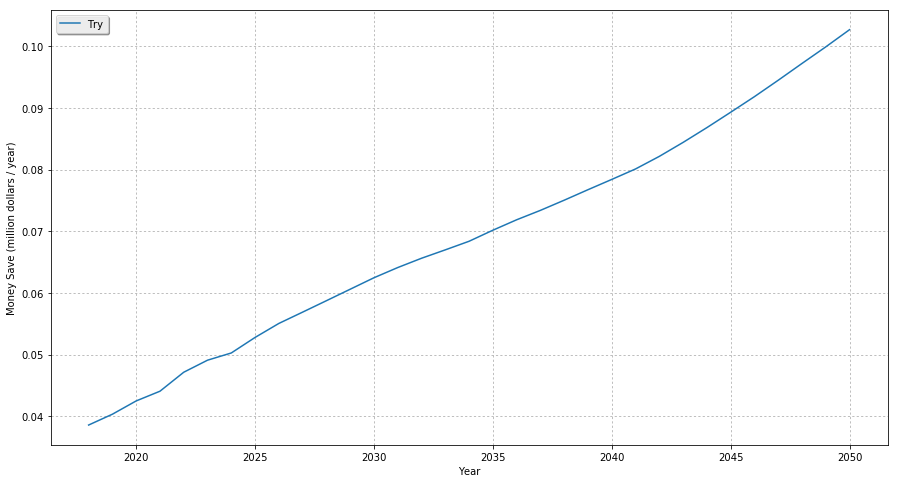

In [34]:
a = rev_plot(30, 500, 'total', 'Try', 10, 3)
a

In [13]:
np.array(b)[:, 2]

array(['Coal', 'NG', 'Petro', 'Hydro', 'Wind'], 
      dtype='<U32')

In [14]:
# The function returns the average cost of resources by multiple their average cost with vote results
def avg_cost(vote):
    """
    set original resources cost euqal to zero
    for state in vote keys
        average cost of resource = average cost of particular resource in specific state * vote results of specific state
    creat a dictionary to store average cost for each type of resource
    return average cost dictinary
    """
    import pandas as pd
    cost = pd.read_csv('../Arranged_Data/Cost/df_cost.csv')
    coal_sum = 0
    ng_sum = 0
    petro_sum = 0
    hydro_sum = 0
    solar_sum = 0
    wind_sum =0
    for i in vote.keys():
        coal_sum += int(cost.Coal[cost.State == i]) * vote[i]
        ng_sum += int(cost.NG[cost.State == i]) * vote[i]
        petro_sum += int(cost.Petro[cost.State == i]) * vote[i]
        hydro_sum += int(cost.Hydro[cost.State == i]) * vote[i]
        solar_sum += int(cost.solar[cost.State == i]) * vote[i]
        wind_sum += int(cost.WindCost[cost.State == i]) * vote[i]
    avg_cost_dict = {'Coal':coal_sum, 'NG':ng_sum, 'Petro':petro_sum, 'Hydro':hydro_sum, 'Solar':solar_sum, 'Wind':wind_sum}
    return avg_cost_dict

In [15]:
avg_cost(ease.rf(2, 75, 30, 1.5))

{'Coal': 25.341000000000005,
 'Hydro': 85.0,
 'NG': 49.92820000000001,
 'Petro': 163.43079999999998,
 'Solar': 127.12839999999998,
 'Wind': 37.0304}

In [16]:
# distinguish the type of resource, either belong to conventional or clean
def clean_or_conv(possible_type_list):
    """
    initialize a null list to store conventional resource
    initialize a null lsit to store clean resource
    for some type in all types
        if type equals coal, natural gas, or petroleum, append it to conventional lsit
        elseif type equals hydro, soalr, or wind, append it to clean list
    retun conventional list, clean list
    """
    clean_list = []
    conventional_list = []
    for i in possible_type_list:
        if i[2] == 'Coal' or i[2] == 'NG' or i[2] == 'Petro':
            conventional_list.append(i)
        elif i[2] == 'Hydro' or i[2] == 'Solar' or i[2] == 'Wind':
            clean_list.append(i)
    return conventional_list, clean_list

In [17]:
conv, clean = clean_or_conv([[0.95810457341493549, 3427272.05, 'Coal'],
 [-0.8923811497455455, 601160.0700000001, 'NG'],
 [0.99926594657247059, 132529.37000000002, 'Petro'],
 [-0.90421357886564524, 159063.21, 'Hydro'],
 [-0.83811357367028649, 149414.79999999996, 'Wind']])
clean

[[-0.9042135788656452, 159063.21, 'Hydro'],
 [-0.8381135736702865, 149414.79999999996, 'Wind']]

In [18]:
# pick the type of resource based on its p value
def sort_and_pick(source_list):
    """"""
    source_list.sort()
    if len(source_list) == 3:
        ref = source_list[2]
        if abs(source_list[2][0] - source_list[1][0]) < 0.05 and abs(source_list[1][0] - source_list[0][0]) < 0.05 :
            for i in source_list:
                if i[1] > ref[1]:
                    ref = i
        elif abs(source_list[2][0] - source_list[1][0]) < 0.05 and abs(source_list[1][0] - source_list[0][0]) >= 0.05:
            if source_list[1][1] > ref[1]:
                ref = source_list[1]
    elif len(source_list) == 2:
        ref = source_list[1]
        if abs(source_list[1][0] - source_list[0][0]) < 0.05 :
            if source_list[0][1] > ref[1]:
                ref = source_list[0]
    elif len(source_list) == 1:
        ref = source_list[0]
    else:
        ref = []
    return ref

In [19]:
sort_and_pick(conv)

[0.9581045734149355, 3427272.05, 'Coal']

In [63]:
def suggest(prec, ts, tw, ws, capacity):
    """
    if no clean resource, clean revenue equals zero, calculate conventinal capacity and plot revenue from conventioan resource
    else electricity generated by clean resource greater or equal than client input capacity, plot revenue from clean resouece
        electricity generated by clean resource less than client input capacity, plot conventinal revenue, clean revenue, and total revenue
    return clean revenue, conventinal revenue, total revenue
    """
    source_co2 = {'Coal':2133, 'Petro':1700, 'NG':1220}
    state_vote = rf(prec, ts, tw, ws)
    cap = avg_capacity(state_vote)
    cost = avg_cost(state_vote)
    source_list = possible_type(cap)
    conventional, clean = clean_or_conv(source_list)
    conventional = sort_and_pick(conventional)
    clean = sort_and_pick(clean)
    df = pd.DataFrame()
    if len(clean) == 0:
        capacity = min([conventional[1], capacity])
        revenue_clean = None
        revenue_conv = rev_plot(cost[conventional[2]], capacity, 'conventional', conventional[2])
        revenue_conv.title('Money Save using ' + conventional[2] + ' (capacity = ' + str(capacity) + ' Mwh)')
        revenue_total = None
    else:
        if clean[1] >= capacity:
            revenue_clean = rev_plot(cost[clean[2]], capacity, 'clean', clean[2])
            revenue_clean.title('Money Save using ' + clean[2] + ' (capacity = ' + str(capacity) + ' Mwh)')
            revenue_conv = None
            revenue_total = None
        else:
            plt.figure(1, figsize = (15, 8))
            plt.subplot(121)
            revenue_clean = rev_plot(cost[clean[2]], clean[1], 'clean', clean[2] + ' (capacity = ' + str(int(clean[1])) + ' Mwh)')
            revenue_conv = rev_plot(cost[conventional[2]], (capacity - clean[1]), 'conventional', conventional[2] + ' (capacity = ' + str(int(capacity - clean[1])) + ' Mwh)')
            revenue_total = rev_plot(cost[clean[2]], clean[1], 'total', 'Total (capacity = ' + str(capacity) + ' Mwh)', avg_cost_conv = cost[conventional[2]], capacity_conv = (capacity - clean[1]))
            revenue_total.title('Money Save using ' + clean[2] + ' Combined with ' + conventional[2])
            for k in conventional:
                if k in source_co2:
                    conversion_to_co2 = source_co2[k]
            print('Emitted Co2 using', conventional[2], 'is:', int(capacity - clean[1]) * conversion_to_co2 * 0.000453592, 'metric tons')
            df['Year'] = [2016, 2050]
            df['CO2_emission'] = [capacity * conversion_to_co2 * 0.000453592, capacity - clean[1] * conversion_to_co2 * 0.000453592]
            plt.subplot(122)
            co2_plot = plt.bar(df.Year, df.CO2_emission, width = 12, color = '#6495ED')
            plt.xticks(df.Year, ('Pure Conventional', 'Conventional + Clean'))
            plt.xlabel('Profiles')
            plt.ylabel('CO2 Emission (Metric Tons)')
            plt.grid(linestyle = 'dotted')
            plt.title('CO2 Emission Comparison Graph')
            autolabel(co2_plot)
    return revenue_clean, revenue_conv, revenue_total, co2_plot

Emitted Co2 using Coal is: 187141.925047536 metric tons


(<module 'matplotlib.pyplot' from '/Users/IvanC/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/Users/IvanC/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/Users/IvanC/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>,
 <Container object of 2 artists>)

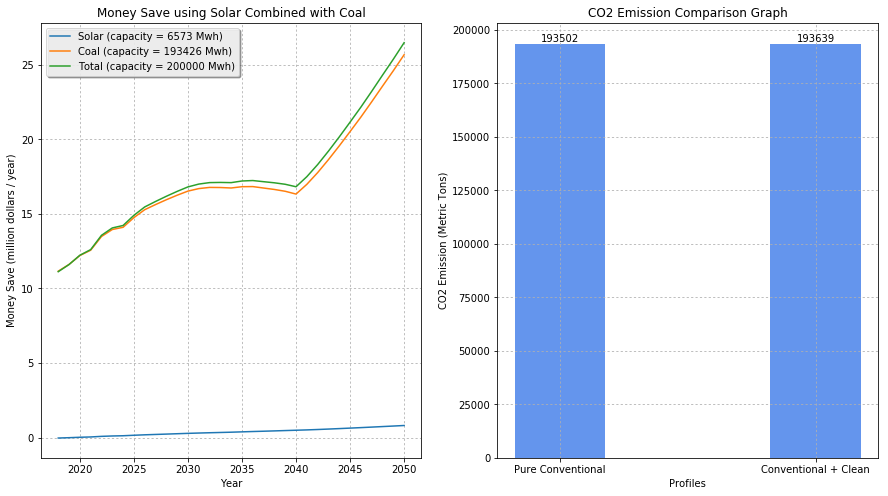

In [64]:
suggest(2, 75, 50, 1.5, 200000)

In [62]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its values, or heights
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1*height,
                '%d' % int(height),
                ha='center', va='bottom')
    return

193502.3472
193182


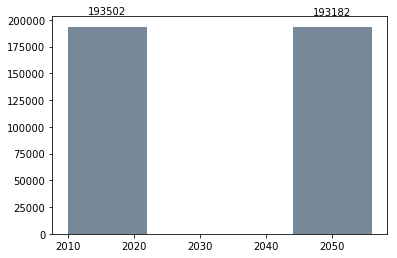

In [55]:
df = pd.DataFrame()
capacity = 200000
clean = 6818
conventional_after_clean = capacity - clean
conversion_to_co2 = 2133
conversion_to_MT = 0.000453592
df['Year'] = [2016, 2050]
df['CO2_emission'] = [pure_conventional, conventional_after_clean]

pure_conventional = capacity * conversion_to_co2 * conversion_to_MT
conventional_clean = conventional_after_clean * conversion_to_co2 * conversion_to_MT
print(pure_conventional)
print(conventional_after_clean)
fig, ax = (1, )
co2_plot = ax.bar(df.Year, df.CO2_emission, width = 12, color = '#778899')
autolabel(co2_plot)